BloomTech Data Science

*Unit 2, Sprint 2, Module 1*

---

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.


## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle competition website (the URL is given on Canvas). Go to the **Rules** page. Accept the rules of the competition and download the dataset. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [5]:
%%capture
!pip install category_encoders==2.*
!pip install ydata_profiling==4.*

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [9]:
df = wrangle("train_features.csv", "train_labels.csv")
X_test = wrangle("test_features.csv")

In [10]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,...,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,...,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,...,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional


In [11]:
X_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,NaN,Lake Tanganyika,Shinyanga,17,5.0,NaN,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
14530,NaN,NaN,32.832815,-4.944937,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
62607,10.0,1675.0,35.488289,-4.242048,NaN,Internal,Manyara,21,1.0,148.0,...,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
46053,NaN,NaN,33.140828,-9.059386,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,never pay,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
47083,50.0,1109.0,34.217077,-4.430529,NaN,Internal,Singida,13,1.0,235.0,...,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [12]:
target = "status_group"
X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [14]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [20]:
model_dt = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         DecisionTreeClassifier(random_state=42, max_depth=15))

model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             2
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=15, random_state=42))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [21]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.856635538603183
Validation Accuracy Score: 0.7647306397306397


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

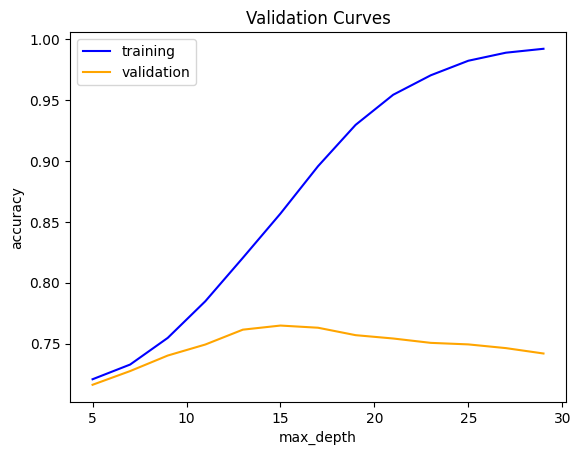

In [19]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6

depths = range(5, 30, 2)

train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(OrdinalEncoder(),
                             SimpleImputer(),
                             DecisionTreeClassifier(max_depth=depth, random_state=42))

  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='orange', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Validation Curves')
plt.legend()
plt.show()

### I am going to go ahead and pick max depth of 15. seems like that will give us the highest accuracy for the validation set, and the gap between the scores isn't as large.

# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


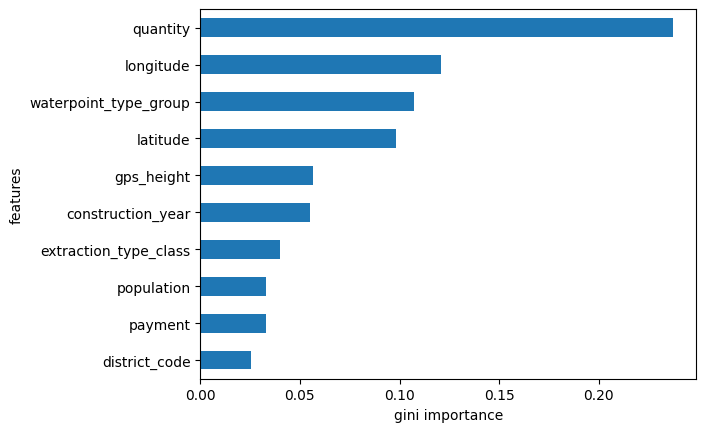

In [22]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini_importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini_importances, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features');
plt.xlabel('gini importance');

In [23]:
predictions = pd.DataFrame(data=model_dt.predict(X_test), index=X_test.index)

In [24]:
predictions.columns = ['status_group']

In [25]:
predictions.to_csv("Assignment.csv")

In [26]:
from google.colab import files
files.download('Assignment.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>